In [23]:
# Part 0 - Creeu un Jupyter notebooks i configureu una connexió amb l'escena Coppelia.
import coppeliasim_zmqremoteapi_client
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np

def connect(port=23000):
    try:
        client = RemoteAPIClient('127.0.0.1', port)
        print(f"Connected to CoppeliaSim on port {port}")
        return client
    except Exception as e:
        print(f"Could not connect to CoppeliaSim on port {port}: {e}")
        return None

client = connect()
sim = client.getObject('sim')

# Obtenim joint handlers
joints = [sim.getObjectHandle(f'/m{i+1}') for i in range(6)]

# Obtenir vision sensor handler
vision_sensor = sim.getObjectHandle('/Vision_sensor')

# Obtenir handles dels cubs
cubes = [sim.getObjectHandle(f'/Cuboid[{i}]') for i in range(4)]

# Obtenir handlers de les safates
planes = [sim.getObjectHandle(f'/Plane[{i}]') for i in range(4)]

print("Joint handles:", joints)
print("Vision sensor handle:", vision_sensor)
print("Cube handles:", cubes)
print("Plane handles:", planes)

Connected to CoppeliaSim on port 23000
Joint handles: [16, 18, 20, 22, 24, 26]
Vision sensor handle: 37
Cube handles: [36, 38, 39, 40]
Plane handles: [41, 42, 43, 44]


In [24]:
# Part 0 -  i feu moure tots els motors del robot.

import time

# Exemple: Movem cada articulació a una posició diferent i després torneu-la a zero
target_positions = [0.5, -0.5, 0.5, -0.5, 0.5, -0.5]  # radians

# Movem a les posicions objectiu
for joint, pos in zip(joints, target_positions):
    sim.setJointTargetPosition(joint, pos)
print("Moved joints to target positions.")
time.sleep(2)  # Wait for 2 seconds to observe the movement

# Moveu de nou a zero
for joint in joints:
    sim.setJointTargetPosition(joint, 0)
print("Moved joints back to zero.")

Moved joints to target positions.
Moved joints back to zero.


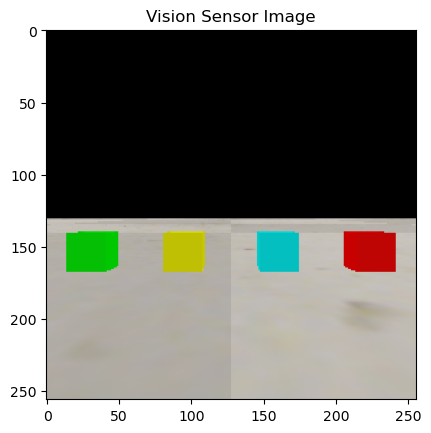

In [12]:
# Part 1 - capturem imatge del sensor
import cv2
import matplotlib.pyplot as plt

img, resX, resY = sim.getVisionSensorCharImage(vision_sensor)

# Convertim la imatge a un array de NumPy i la reformatem
image = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
image = np.flipud(image)  # Flip vertically if needed

# Mostra la imatge per verificar-la (el robot ha de estar en simulació)
import matplotlib.pyplot as plt
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(image)
plt.title("Vision Sensor Image")
plt.show()

Green cube:
  Detected image position: (x=32, y=154), size (w=36, h=28)
  Estimated world position: (x=0.175, y=0.075), distance=0.190 m
  Simulation world position: (x=0.175, y=0.075, z=0.010)
------------------------------------------------------------
Yellow cube:
  Detected image position: (x=95, y=154), size (w=29, h=28)
  Estimated world position: (x=0.175, y=0.026), distance=0.177 m
  Simulation world position: (x=0.175, y=0.025, z=0.010)
------------------------------------------------------------
Cyan cube:
  Detected image position: (x=160, y=154), size (w=29, h=28)
  Estimated world position: (x=0.175, y=-0.025), distance=0.177 m
  Simulation world position: (x=0.175, y=-0.025, z=0.010)
------------------------------------------------------------
Red cube:
  Detected image position: (x=224, y=154), size (w=36, h=28)
  Estimated world position: (x=0.175, y=-0.075), distance=0.190 m
  Simulation world position: (x=0.175, y=-0.075, z=0.010)
-------------------------------------

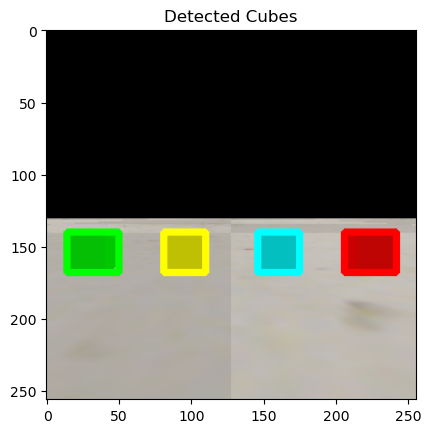

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Definim els rangs de color en RGB
color_ranges = {
    "green":  (np.array([0, 120, 0]),   np.array([100, 255, 100])),
    "yellow": (np.array([180, 180, 0]), np.array([255, 255, 120])),
    "cyan":   (np.array([0, 180, 180]), np.array([80, 255, 255])),
    "red":    (np.array([180, 0, 0]),   np.array([255, 80, 80]))
}

# Per a la visualització, assignem un color a cada caixa delimitadora
box_colors = {
    "green":  (0, 255, 0),
    "yellow": (255, 255, 0),
    "cyan":   (0, 255, 255),
    "red":    (255, 0, 0)
}

# Mapejem el nom dels colors als índexs dels cubs a la simulació
cube_indices = {
    "cyan": 0,
    "yellow": 1,
    "red": 2,
    "green": 3
}

# Obtenim les posicions reals de la simulació
cube_positions_sim = {}
for color, idx in cube_indices.items():
    pos = sim.getObjectPosition(cubes[idx], -1)
    cube_positions_sim[color] = pos

# Calibració: mapeig de x de la imatge (píxels) a y en el món (metres)
def img_to_world(cx, cy):
    # Mapeig lineal per a y_món (lateral)
    m = -0.00078125
    c = 0.1
    y_world = m * cx + c
    # x_món és constant per aquesta configuració (tots els cubs a la mateixa profunditat)
    x_world = 0.175
    # Distància real des de la càmera (0,0) al centre del cub
    d = np.sqrt(x_world**2 + y_world**2)
    return x_world, y_world, d

# Detecta els cubs a la imatge i compara les posicions
image_with_boxes = image.copy()
cube_count = 0
detected_positions = {}
estimated_world_positions = {}

for color, (low, high) in color_ranges.items():
    mask = cv2.inRange(image, low, high)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cnts = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2]
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w > 10 and h > 10:
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), box_colors[color], 3)
            cx, cy = x + w // 2, y + h // 2
            detected_positions[color] = (cx, cy)
            # Estimeu la posició al món des de la imatge
            xw, yw, dist = img_to_world(cx, cy)
            estimated_world_positions[color] = (xw, yw, dist)
            # Obteniu la posició de la simulació
            sim_pos = cube_positions_sim[color]
            print(f"{color.capitalize()} cube:")
            print(f"  Detected image position: (x={cx}, y={cy}), size (w={w}, h={h})")
            print(f"  Estimated world position: (x={xw:.3f}, y={yw:.3f}), distance={dist:.3f} m")
            print(f"  Simulation world position: (x={sim_pos[0]:.3f}, y={sim_pos[1]:.3f}, z={sim_pos[2]:.3f})")
            print("-" * 60)
            cube_count += 1

print(f"Total cubes detected: {cube_count}")
plt.imshow(image_with_boxes)
plt.title("Detected Cubes")
plt.show()

In [22]:
# obtenim les mesures dels braços


import numpy as np
import time

# 1) Mesura de les longituds
p1 = np.array(sim.getObjectPosition(joints[0], -1))  # m1 base
p2 = np.array(sim.getObjectPosition(joints[1], -1))  # m2
p3 = np.array(sim.getObjectPosition(joints[2], -1))  # m3 (twist)
p4 = np.array(sim.getObjectPosition(joints[3], -1))  # m4 → acabat “colze”

H  = np.linalg.norm(p2 - p1)       # offset vertical base→m2
b  = np.linalg.norm(p3 - p2)       # “braç superior”
ab = np.linalg.norm(p4 - p3)       # “antebraç” (extensió colze→wrist)

print(f"H={H:.3f}, b={b:.3f}, ab={ab:.3f} m")

H=0.024, b=0.054, ab=0.030 m


In [11]:
# Obteniu les posicions en el marc mundial de les safates/planos
tray_names = ['yellow', 'red', 'green', 'blue']
tray_positions = {}

for i, color in zip([3, 2, 1, 0], tray_names):
    pos = sim.getObjectPosition(planes[i], -1)  # -1 indica el marc mundial
    tray_positions[color] = pos
    print(f"{color.capitalize()} tray (Plane[{i}]) position: {pos}")


Yellow tray (Plane[3]) position: [0.05000000447034836, 0.11999999731779099, 0.0020000000949949026]
Red tray (Plane[2]) position: [-0.09999997913837433, 0.11999999731779099, 0.0020000000949949026]
Green tray (Plane[1]) position: [0.05000000447034836, -0.11999999731779099, 0.0020000000949949026]
Blue tray (Plane[0]) position: [-0.10000000149011612, -0.11999999731779099, 0.0020000000949949026]


In [12]:
import numpy as np

# Obteniu la posició de cada articulació respecte al marc mundial
pos_m1 = sim.getObjectPosition(joints[0], -1)  # base
pos_m2 = sim.getObjectPosition(joints[1], -1)  # després de l'alçada
pos_m3 = sim.getObjectPosition(joints[2], -1)  # colze
pos_grip = sim.getObjectPosition(joints[5], -1)  # pinça

# Calculeu les distàncies
l1 = np.linalg.norm(np.array(pos_m2) - np.array(pos_m1))   # vertical
l2 = np.linalg.norm(np.array(pos_m3) - np.array(pos_m2))   # primer segment (braç 1)
l3 = np.linalg.norm(np.array(pos_grip) - np.array(pos_m3)) # segon segment fins a la pinça (braç 2)

# Imprimiu els resultats
print(f"l1 (vertical):     {l1:.4f} m")
print(f"l2 (braç 1):       {l2:.4f} m")
print(f"l3 (braç 2):       {l3:.4f} m")



l1 (vertical):     0.0240 m
l2 (braç 1):       0.0540 m
l3 (braç 2):       0.1149 m


In [14]:
# Cel·la X – Test manual pas a pas de joints

import math
import time

# ──────────────────────────────────────────────────
# 1) EDITA AQUESTA LLISTA amb els graus que vulguis:
manual_deg = [
    23,    # m1 (base) solo rota
    80,    # m2 (braç superior)hombro conectado a base a más angulo más baja el brazo, 90º lo pone gorizontal, 0 vertical y negativo hacia atras
    -0,   # m3 (colze)
    00,     # m4 (roll canell)
    90,   # m5 (pitch canell, pinça vertical) muñeca
    0.12   # m6 (obertura pinça, en rad)
]

manual_deg = [
    23,    # m1 (base) 
    80,    # m2 (braç superior)
    -0,   # m3 (colze)
    00,     # m4 (roll canell)
    90,   # m5 (pitch canell, pinça vertical) 
    0.12   # m6 (obertura pinça, en rad)
]
# ──────────────────────────────────────────────────

# 2) Converteix graus a radians
manual_rad = [math.radians(a) for a in manual_deg[:5]] + [manual_deg[5]]

# 3) Mou cada joint a la posició desitjada
for j_handle, ang in zip(joints, manual_rad):
    sim.setJointTargetPosition(j_handle, ang)

# 4) Deixa que la simulació acabi el moviment
time.sleep(0.5)

# 5) Imprimeix què has aplicat i on queden l'extrem del 3r link i la punta de la pinça
print("Angles manuals aplicats (º):", manual_deg)
p_wrist = sim.getObjectPosition(joints[3], -1)
print("Wrist-centre (joint4):", p_wrist)
tip_hdl = sim.getObjectHandle('holder_visual')  # o posa l'alias complet que tinguis
p_tip = sim.getObjectPosition(tip_hdl, -1)
print("Punta pinça (holder_visual):", p_tip)


Angles manuals aplicats (º): [23, 80, 0, 0, 90, 0.12]
Wrist-centre (joint4): [0.060768680046053, 0.032756760140811816, 0.06629555634969743]
Punta pinça (holder_visual): [0.16241021415912005, 0.0716052610418289, 0.029821484238691933]
